# Online Retails Purchase

### Introduction:



### Step 1. Import the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as t
import requests
import os

In [2]:
os.chdir('/tf/pyspark_exercises/07_Visualization/Online_Retail/')


### Step 2. Import the dataset from this [address](https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/07_Visualization/Online_Retail/Online_Retail.csv). 

### Step 3. Assign it to a variable called online_rt
Note: if you receive a utf-8 decode error, set `encoding = 'latin1'` in `pd.read_csv()`.

In [3]:
spark = SparkSession.builder\
                    .appName('retail')\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 18:07:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
url = 'https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/07_Visualization/Online_Retail/Online_Retail.csv'

get_url = requests.get(url)

with open('data.csv', 'w', encoding='utf-8') as f:
    f.writelines(get_url.text)



In [5]:
online_rt = spark.read.csv('data.csv', sep=',', header=True)

In [6]:
online_rt.show()

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/10 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/10 8:26|     4.25|     17850|United

In [7]:
df = pd.read_csv('data.csv', sep=',', header=0)

### Step 4. Create a histogram with the 10 countries that have the most 'Quantity' ordered except UK

## 🐍 **Solución Pyspark** 

In [8]:
online_rt.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [16]:
from pyspark.sql import types as T
online_rt = online_rt.withColumn('Quantity', F.trim(F.col('Quantity'))\
                                              .cast(T.IntegerType()))

In [23]:
all_country_except_uk = online_rt.filter(F.col('Country') != 'United Kingdom')

top_10 = all_country_except_uk.groupBy('Country').agg(F.sum('Quantity').alias('Cantidad total ordenada')).orderBy(F.col('Cantidad total ordenada'), ascending=False).limit(10)

top_10.show()

+-----------+-----------------------+
|    Country|Cantidad total ordenada|
+-----------+-----------------------+
|Netherlands|                 200128|
|       EIRE|                 142637|
|    Germany|                 117448|
|     France|                 110480|
|  Australia|                  83653|
|     Sweden|                  35637|
|Switzerland|                  30325|
|      Spain|                  26824|
|      Japan|                  25218|
|    Belgium|                  23152|
+-----------+-----------------------+



In [25]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [26]:
df['Quantity'] = df['Quantity'].astype(int)

In [36]:
df_filtrado = df[df['Country'] != 'United Kingdom']
top_10_df = df_filtrado.groupby(['Country'], as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False).head(10)

top_10_df

,Country,Quantity
24,Netherlands,200128
10,EIRE,142637
14,Germany,117448
13,France,110480
0,Australia,83653
32,Sweden,35637
33,Switzerland,30325
31,Spain,26824
20,Japan,25218
3,Belgium,23152


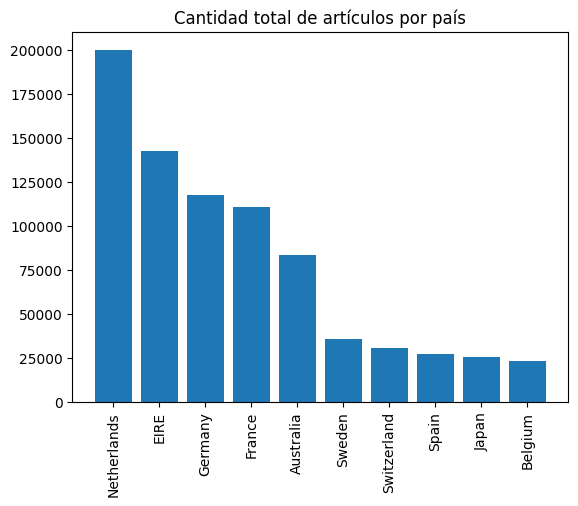

In [43]:
plt.bar(x= top_10_df['Country'], height=top_10_df['Quantity'])
plt.xticks(rotation=90)
plt.title('Cantidad total de artículos por país')
plt.show()

### Step 5.  Exclude negative Quantity entries

In [47]:
online_rt = online_rt.filter(F.col('Quantity')>=0)

In [48]:
online_rt.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows



In [53]:
df = df.loc[df['Quantity']>0, :].copy()

### Step 6. Create a scatterplot with the Quantity per UnitPrice by CustomerID for the top 3 Countries (except UK)

In [58]:
online_rt = online_rt.withColumn('UnitPrice', F.col('UnitPrice').cast(T.FloatType()))

df = online_rt.toPandas()

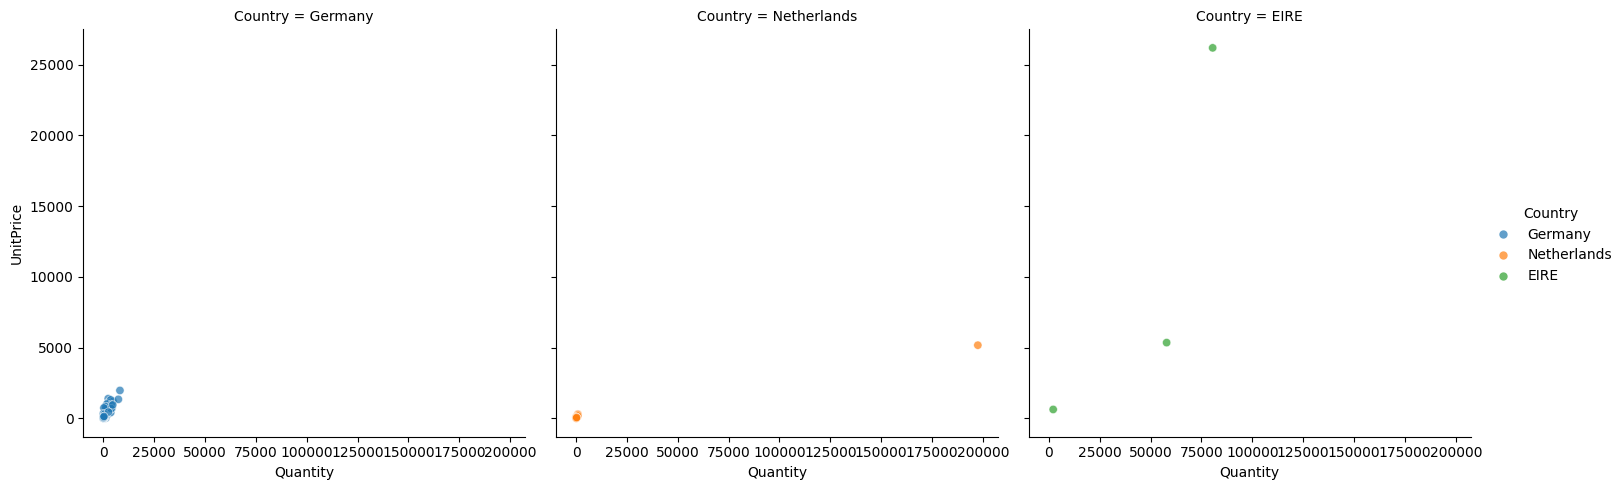

In [ ]:
import seaborn as sns


# Filtrar el DataFrame para incluir solo los países deseados
top_3 = df[df['Country'].isin(['Germany', 'EIRE', 'Netherlands'])]

top_3 = top_3.groupby(['CustomerID', 'Country']).agg({'Quantity': 'sum', 'UnitPrice': 'sum'}).reset_index()

# Crear el catplot
sns.relplot(
    data=top_3,
    x='Quantity',
    y='UnitPrice',
    hue='Country',  
    col='Country', 
    kind='scatter',
    alpha=0.7  
)


### Step 7. Investigate why the previous results look so uninformative.

Saltando porque no viene con el fin del repositorio

### 8. Plot a line chart showing revenue (y) per UnitPrice (x).

Did Step 7 give us any insights about the data? Sure! As average price increases, the quantity ordered decreses.  But that's hardly surprising. It would be surprising if that wasn't the case!

Nevertheless the rate of drop in quantity is so drastic, it makes me wonder how our revenue changes with respect to item price. It would not be that surprising if it didn't change that much. But it would be interesting to know whether most of our revenue comes from expensive or inexpensive items, and how that relation looks like.

That is what we are going to do now.

#### 8.1 Group `UnitPrice` by intervals of 1 for prices [0,50), and sum `Quantity` and `Revenue`.

In [87]:
from pyspark.ml.feature import Bucketizer
import numpy as np

rangos = [float(x) for x in range(0, 51)]  # [0.0, 1.0, 2.0, ..., 50.0]

bucketizer = Bucketizer(
    splits=rangos,
    inputCol="UnitPrice",  # Columna a transformar
    outputCol="PriceRange",  # Nueva columna con el intervalo
    handleInvalid="keep"  # Mantener valores fuera de los splits (ej: 50.1)
)

online_rt_bucketed = bucketizer.transform(online_rt)

online_rt_bucketed.select("UnitPrice", "PriceRange").show(5)

+---------+----------+
|UnitPrice|PriceRange|
+---------+----------+
|     2.55|       2.0|
|     3.39|       3.0|
|     2.75|       2.0|
|     3.39|       3.0|
|     3.39|       3.0|
+---------+----------+
only showing top 5 rows



In [89]:
online_rt_bucketed.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- PriceRange: double (nullable = true)



In [95]:
online_rt_filtered = online_rt.filter((F.col("UnitPrice") >= 0) & (F.col("UnitPrice") < 50))

splits = [float(x) for x in range(0, 51)] 

bucketizer = Bucketizer(
    splits=splits,
    inputCol="UnitPrice",
    outputCol="PriceRange",
    handleInvalid="error"  
)

# Aplicar transformación
online_rt_bucketed = bucketizer.transform(online_rt_filtered)

In [96]:

# Calcular Revenue (Quantity * UnitPrice)
online_rt_with_revenue = online_rt_bucketed.withColumn(
    "Revenue",
    F.col("Quantity") * F.col("UnitPrice")
)

# Agrupar por PriceRange y sumar Revenue y Quantity
revenue_by_price_range = online_rt_with_revenue.groupBy("PriceRange").agg(
    F.sum("Revenue").alias("TotalRevenue"),
    F.sum("Quantity").alias("TotalQuantity")
).orderBy("PriceRange")

revenue_by_price_range.show()

+----------+------------------+-------------+
|PriceRange|      TotalRevenue|TotalQuantity|
+----------+------------------+-------------+
|       0.0|1101322.5581448744|      2190070|
|       1.0| 2698163.107846856|      1847891|
|       2.0|2024032.0676529408|       837903|
|       3.0| 864294.7831845284|       243193|
|       4.0|1219569.0458607674|       269734|
|       5.0| 390263.4259762764|        68129|
|       6.0| 270433.6278128624|        40608|
|       7.0|  296980.228454113|        38831|
|       8.0| 389275.7784547806|        46341|
|       9.0|161907.72659301758|        16484|
|      10.0| 240016.8066921234|        22093|
|      11.0|25251.810007095337|         2211|
|      12.0|201846.29008197784|        15938|
|      13.0|10601.789922714233|          794|
|      14.0| 67363.78940105438|         4553|
|      15.0|28233.789867401123|         1809|
|      16.0| 83763.43906784058|         4998|
|      17.0|227.17999458312988|           13|
|      18.0| 37250.19002914429|   

In [98]:


bins = np.arange(0, 51, 1) 
labels = [f"{i}-{i+1}" for i in range(50)]  


df['Revenue'] = df['Quantity'] * df['UnitPrice']

df['Price_Range'] = pd.cut(df['UnitPrice'], bins=bins, right=False, labels=labels)

# 4. Agrupar por Price_Range y sumar Revenue y Quantity
price_revenue = df.groupby('Price_Range').agg(
    Total_revenue=('Revenue', 'sum'),
    Total_quantity=('Quantity', 'sum')
).reset_index()

print(price_revenue.head())

  Price_Range  Total_revenue  Total_quantity
0         0-1   1.101323e+06         2190070
1         1-2   2.698163e+06         1847891
2         2-3   2.024032e+06          837903
3         3-4   8.642948e+05          243193
4         4-5   1.219569e+06          269734


/tmp/ipykernel_12/2149049510.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_revenue = df.groupby('Price_Range').agg(


#### 8.3 Plot.

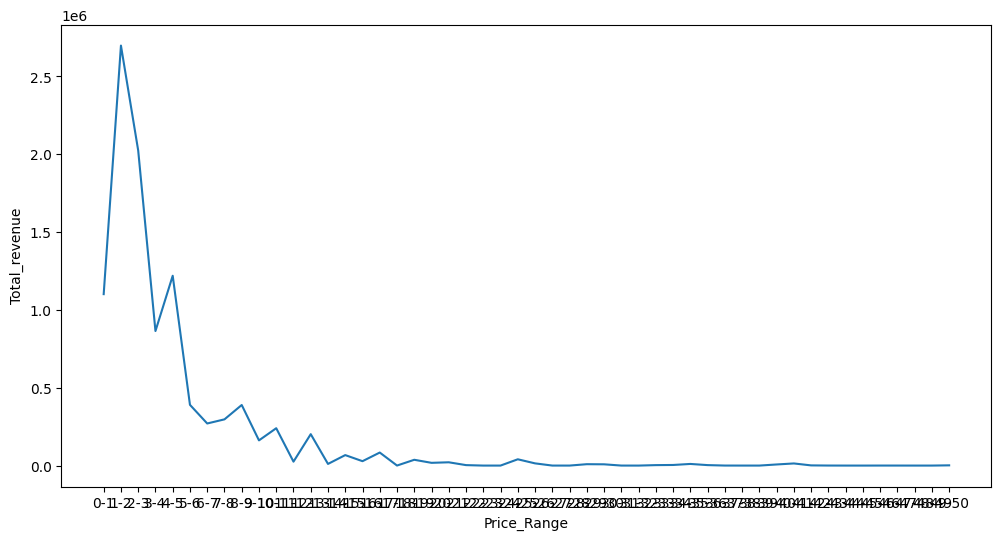

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=price_revenue,
    x='Price_Range',
    y='Total_revenue',

)

plt.show()

#### 8.4 Make it look nicer.
x-axis needs values.  
y-axis isn't that easy to read; show in terms of millions.

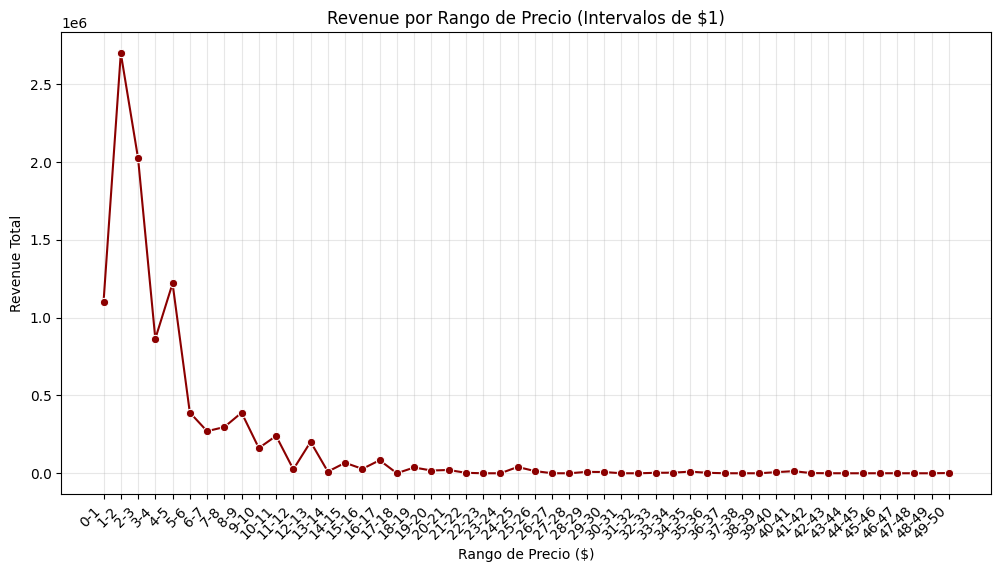

In [105]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=price_revenue,
    x='Price_Range',
    y='Total_revenue',
    marker='o',
    color='darkred'
)

plt.title("Revenue por Rango de Precio (Intervalos de $1)")
plt.xlabel("Rango de Precio ($)")
plt.ylabel("Revenue Total")
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor lectura
plt.grid(alpha=0.3)
plt.show()